# Process Coin Cell Data

Author: Andrew Weng

9/1/2021

Process the coin cell data used to obtain half-cell resistance curves.

Greg Less and Joe helped to build NMC/Li, Gr/Li, and LFP/Li coin cells. These cells were tested with a variant of the HPPC protocol after some conditioning cycles. 

In this notebook, we load, parse, and visualize the results.

In the future, a Python class should be used to handle the data loading and parsing. For now, let's do it all here.

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import numpy as np
import pandas as pd
import glob
import yaml
import pprint
from datetime import datetime
from scipy.stats import ttest_ind
import seaborn as sns
from matplotlib import pyplot as plt
import re

In [2]:
pd.set_option('display.max_rows', 500)

## Configure plot settings

In [3]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Arial'],
                  'size': 18
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (7, 5),
                    'facecolor'  : 'white',
                    'dpi'        : 150
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')

VOLTAGE_LIMITS = (2.95, 4.25)
CAPACITY_LIMITS = (0, 3)

ORANGE = (1, 0.5, 0)
BLUE = (0, 0.5, 1)
BLACK = (0.0, 0.0, 0.0)
GREEN = (0, 0.75, 0)
ORANGE = (1, 0.5, 0)
GREY = (0.9, 0.9, 0.9)

## Load resources

In [4]:
paths = yaml.load(open('paths.yaml', 'r'), Loader=yaml.FullLoader)

DATA_FOLDER = paths['data'] + '2021-08-post-mortem-biologic-pc/'
FILE_GROUP_REGEX_LIST = ['*coin*hppc*.mpt']

file_paths = [sorted(glob.glob(f'{DATA_FOLDER}{f}')) for f in FILE_GROUP_REGEX_LIST]
file_paths

[['/Users/aweng/Documents/fast-formation/data/2021-08-post-mortem-biologic-pc/20210819_coin_nmc111_cell2_hppc_CA2.mpt',
  '/Users/aweng/Documents/fast-formation/data/2021-08-post-mortem-biologic-pc/20210822_coin_graphite_cell7_hppc_CA7.mpt',
  '/Users/aweng/Documents/fast-formation/data/2021-08-post-mortem-biologic-pc/20210822_coin_nmc111_cell2_hppc_2_CA2.mpt',
  '/Users/aweng/Documents/fast-formation/data/2021-08-post-mortem-biologic-pc/20210825_coin_graphite_cell8_hppc_1_CA8.mpt',
  '/Users/aweng/Documents/fast-formation/data/2021-08-post-mortem-biologic-pc/20210825_coin_lfp_cell6_hppc_1_CA4.mpt']]

In [5]:
target_files = [
    DATA_FOLDER + '20210819_coin_nmc111_cell2_hppc_CA2.mpt',
    DATA_FOLDER + '20210822_coin_graphite_cell7_hppc_CA7.mpt',
    DATA_FOLDER + '20210825_coin_lfp_cell6_hppc_1_CA4.mpt'
]

num_header_lines_vec = [
    106, 
    105,
    106
]

applied_current_ma_vec = [
    -0.400,
    -0.400,
    -0.400
]

is_cathode_vec = [
    1,
    0,
    1
]

name_vec = [
    'NMC111',
    'Graphite',
    'LFP'
]


# Sanity check a file

In [6]:
idx = 0

target_file = target_files[idx]
num_header_lines = num_header_lines_vec[idx]
applied_current = applied_current_ma_vec[idx]
is_cathode = is_cathode_vec[idx]
name = name_vec[idx]

df = pd.read_csv(target_file, header=num_header_lines, sep='\t', encoding='ISO-8859-1')
df
df.columns

Index(['mode', 'ox/red', 'error', 'control changes', 'Ns changes',
       'counter inc.', 'Ns', 'I Range', 'time/s', 'control/V/mA', 'Ecell/V',
       'I/mA', 'dq/mA.h', '(Q-Qo)/mA.h', 'Energy/W.h',
       'Q charge/discharge/mA.h', 'half cycle', 'Temperature/°C', 'x',
       'Q discharge/mA.h', 'Q charge/mA.h', 'Capacity/mA.h', 'Efficiency/%',
       'control/V', 'control/mA', 'cycle number', 'P/W', 'R/Ohm',
       'Unnamed: 28'],
      dtype='object')

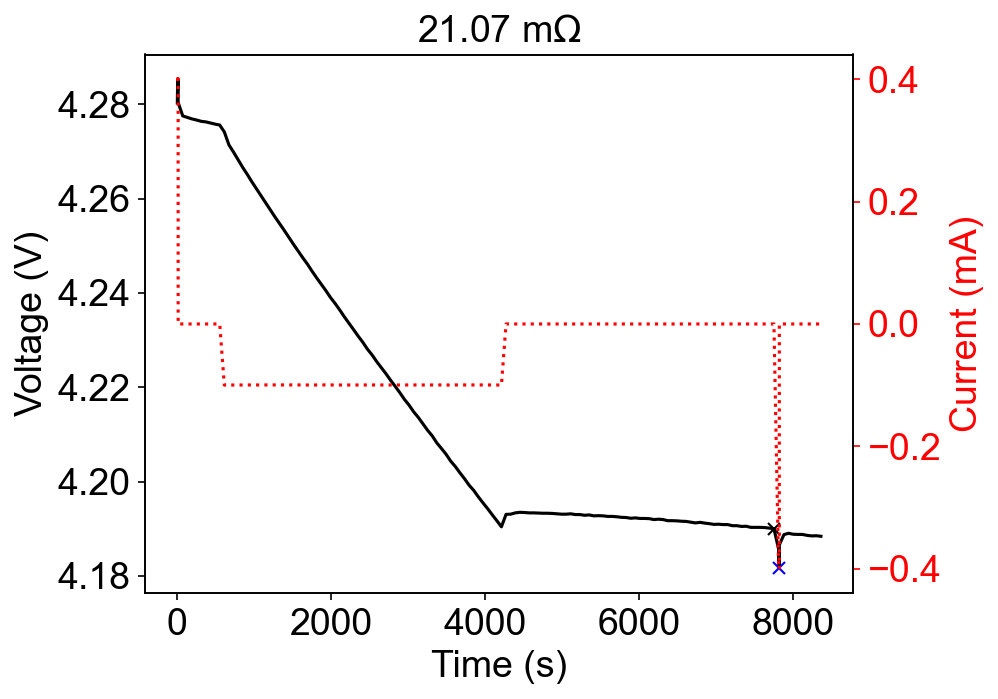

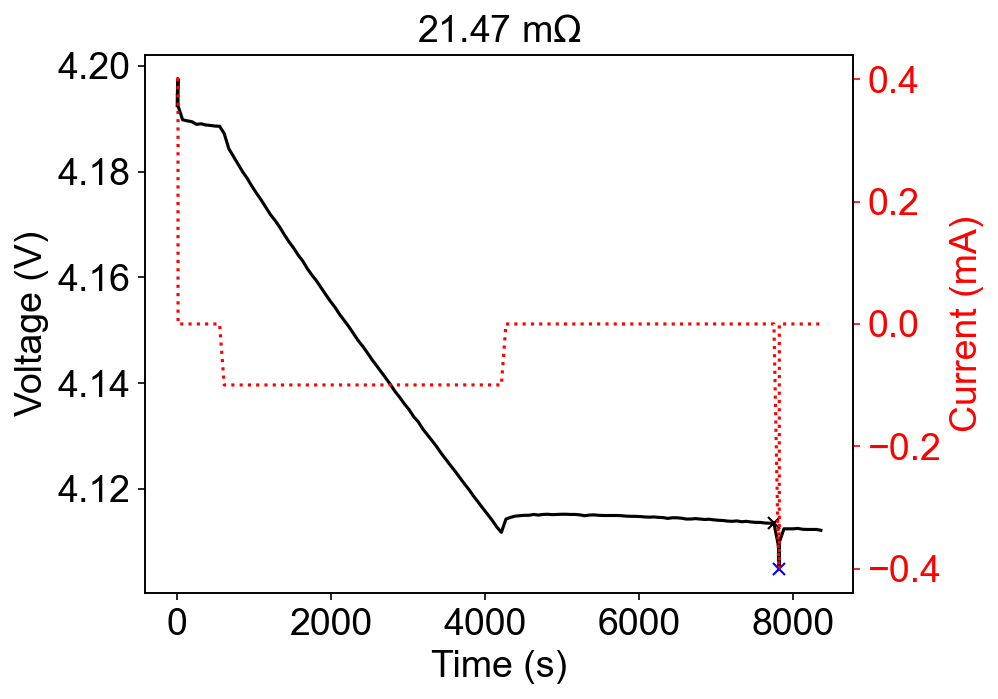

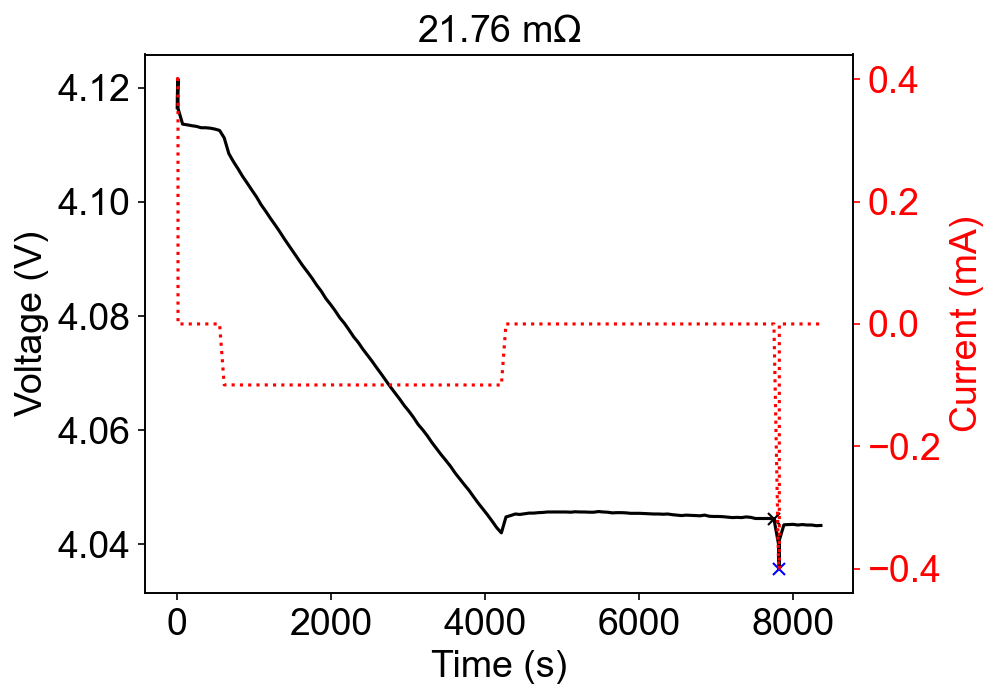

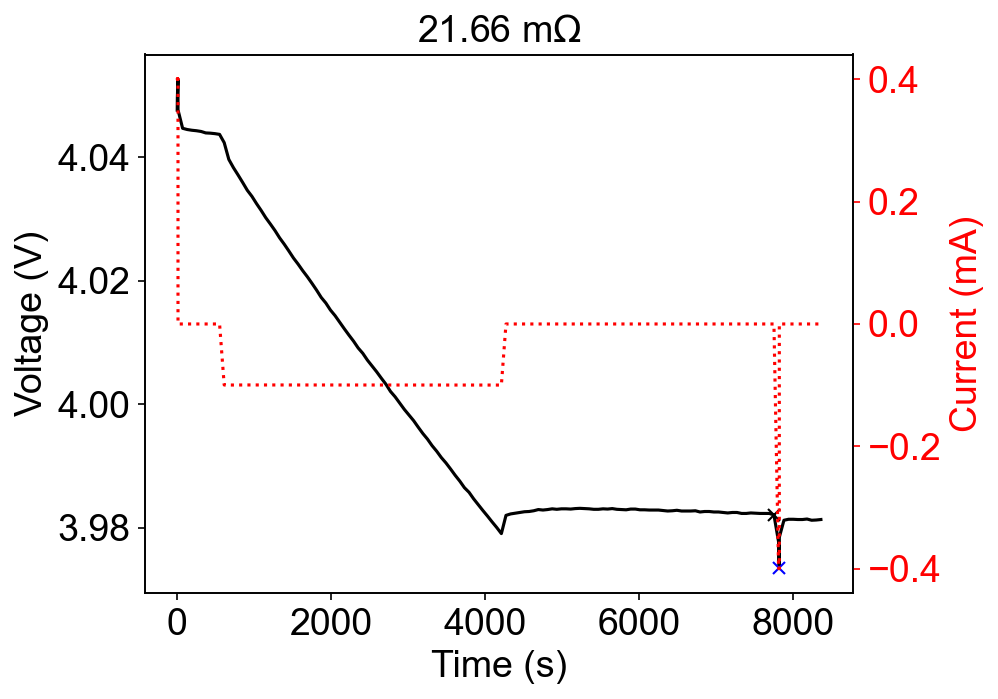

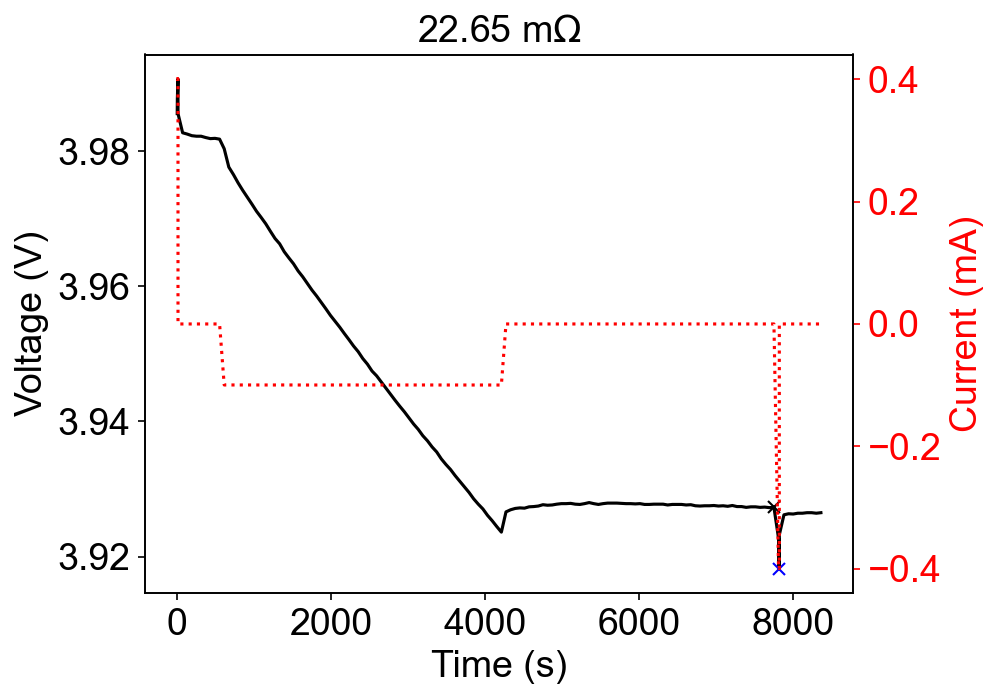

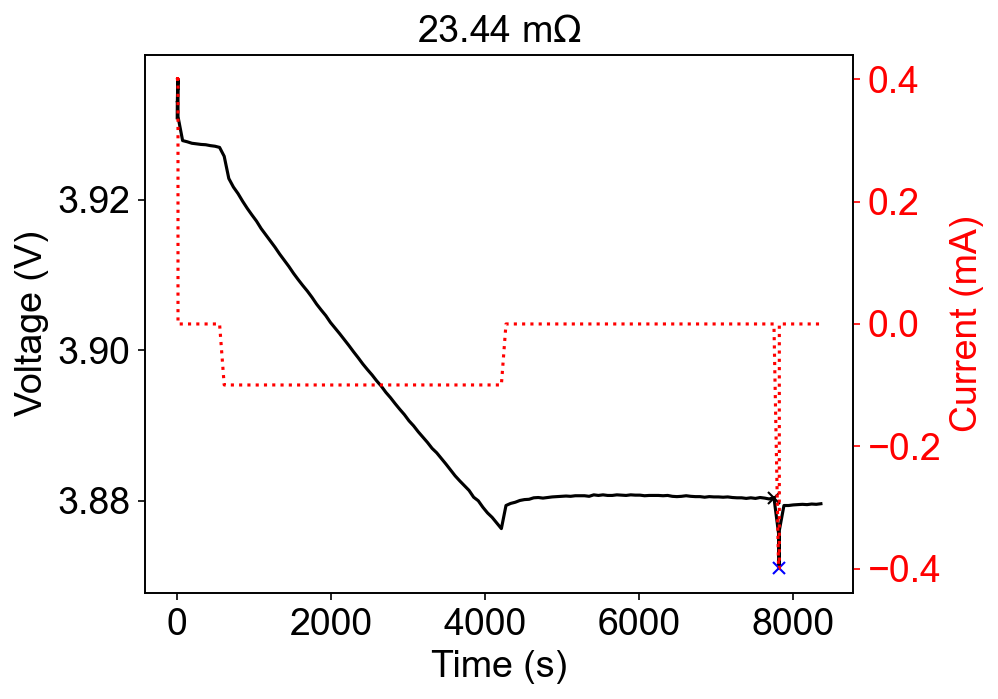

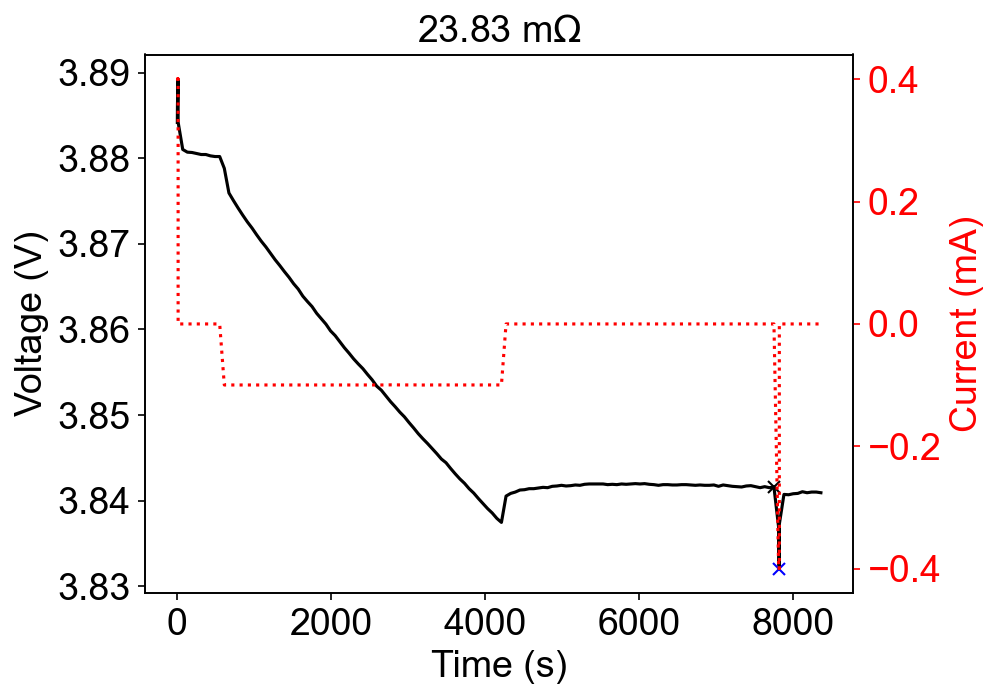

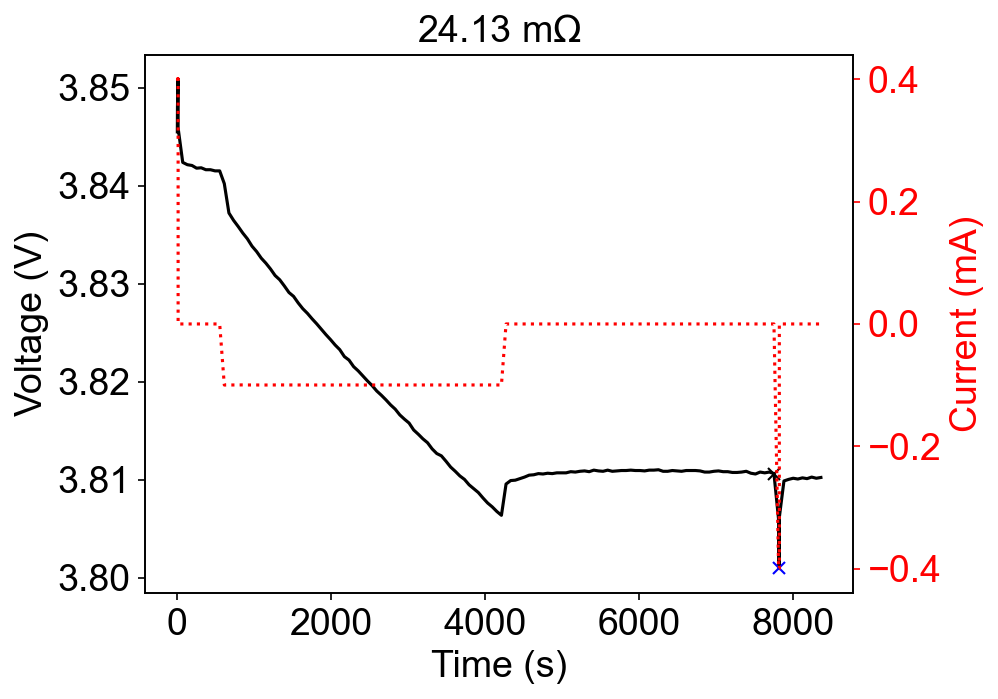

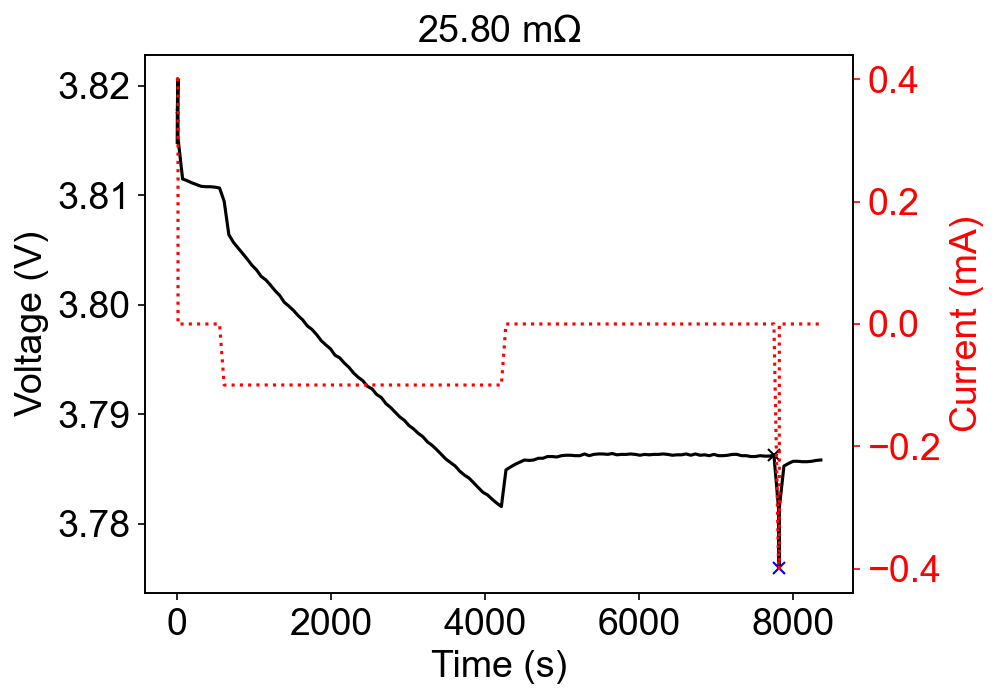

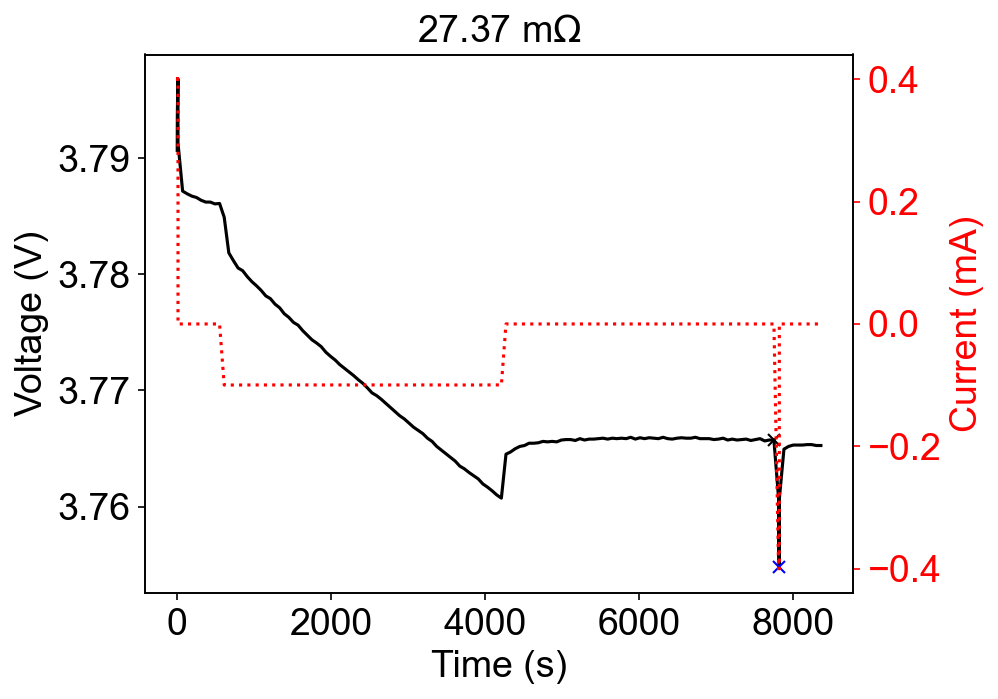

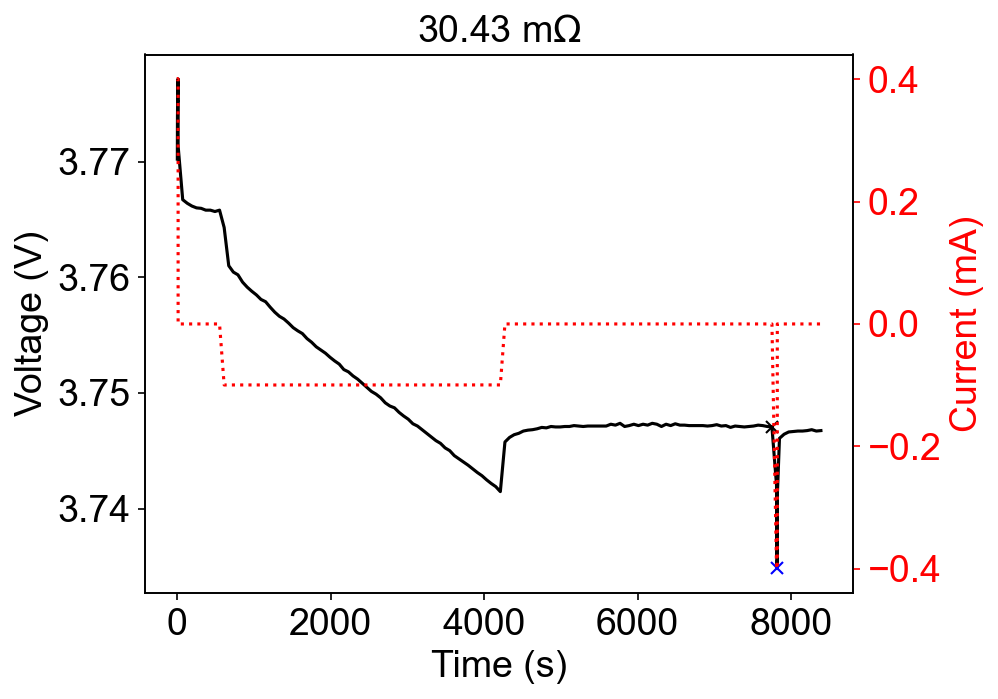

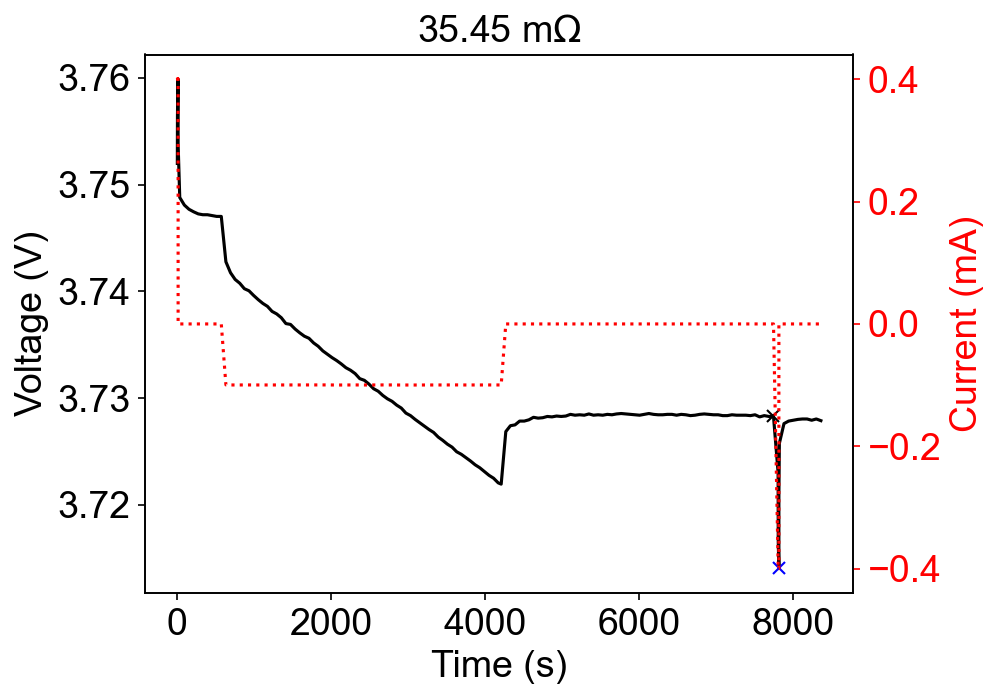

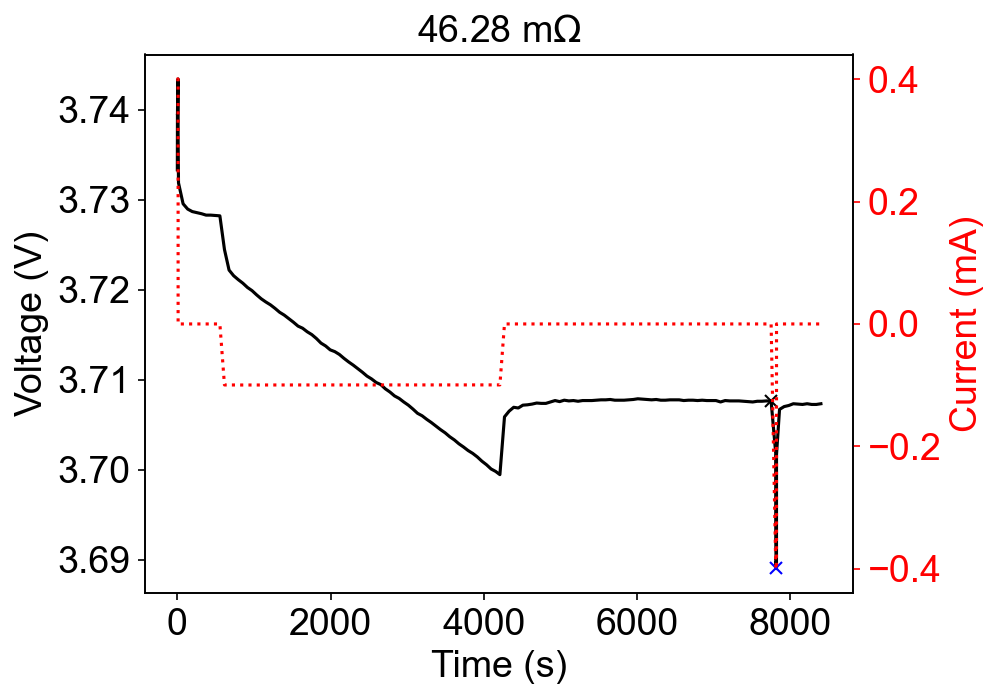

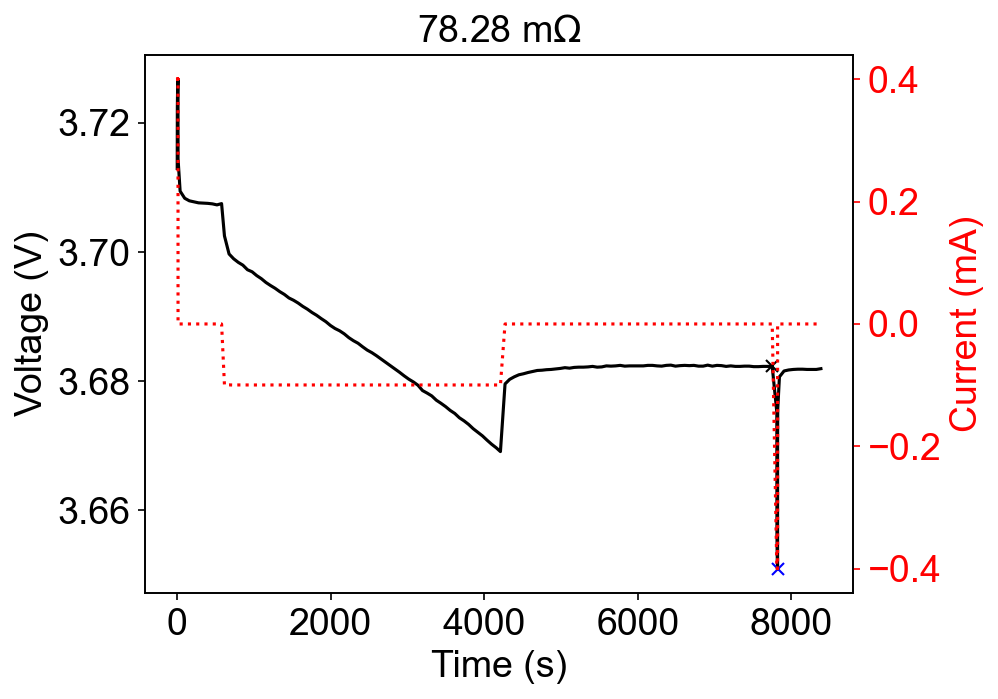

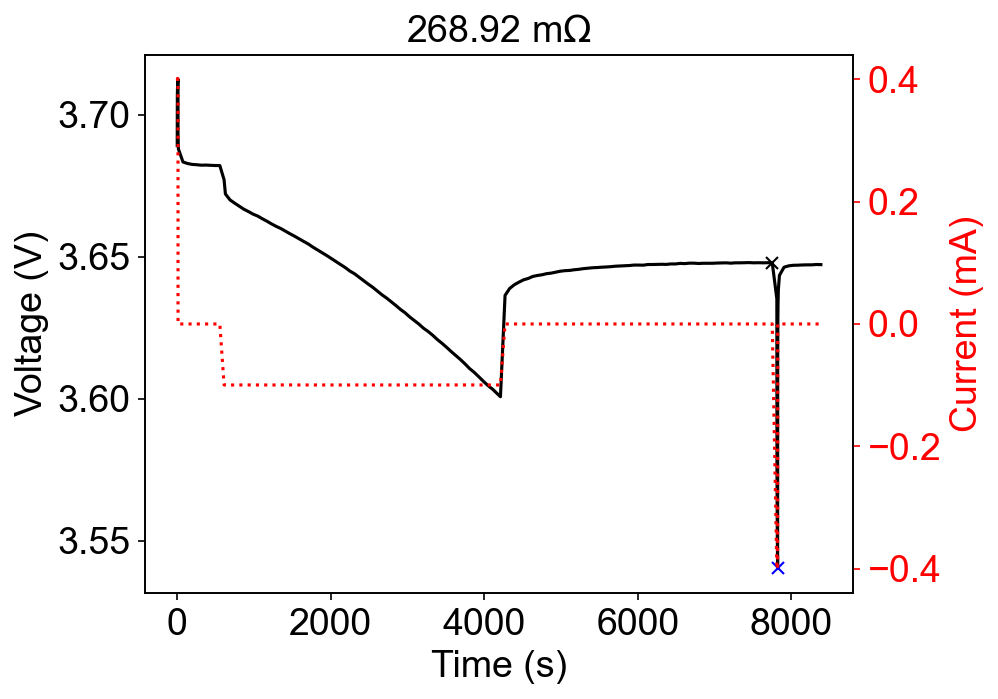

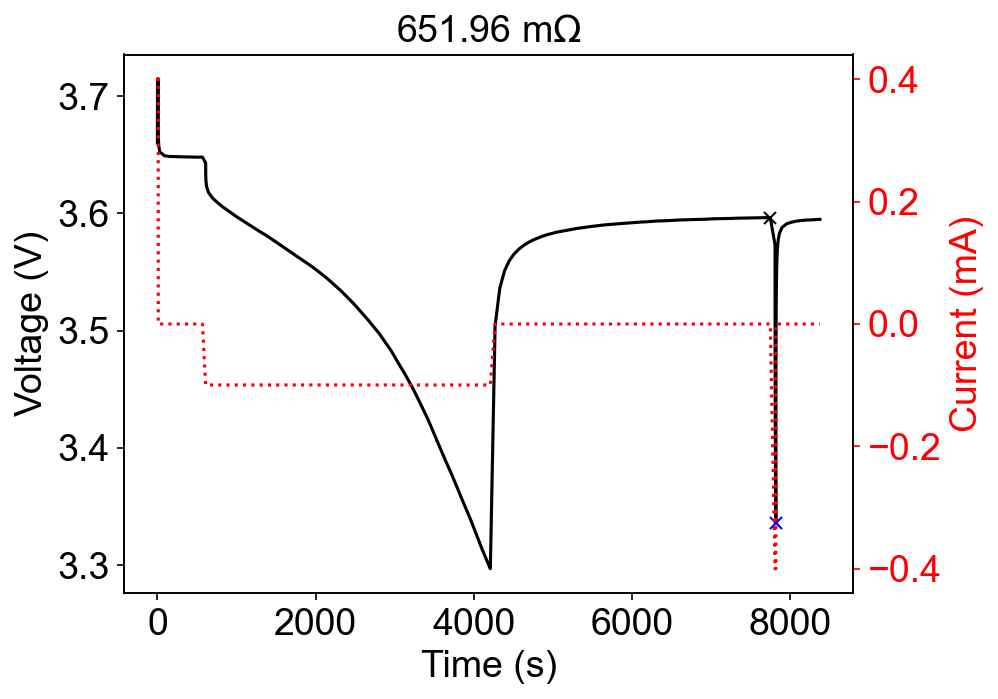

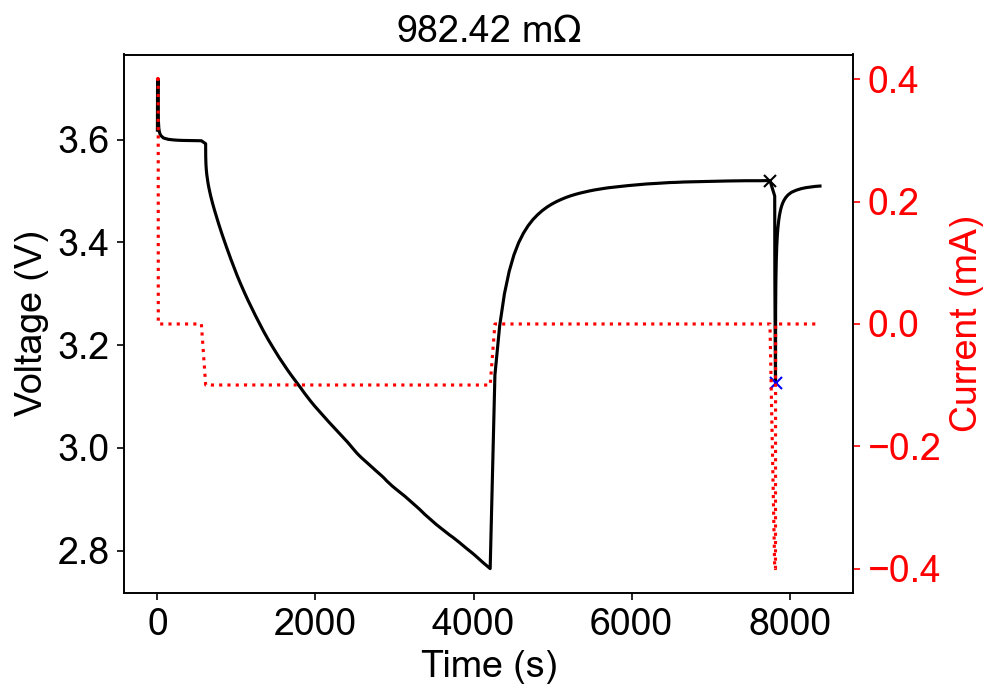

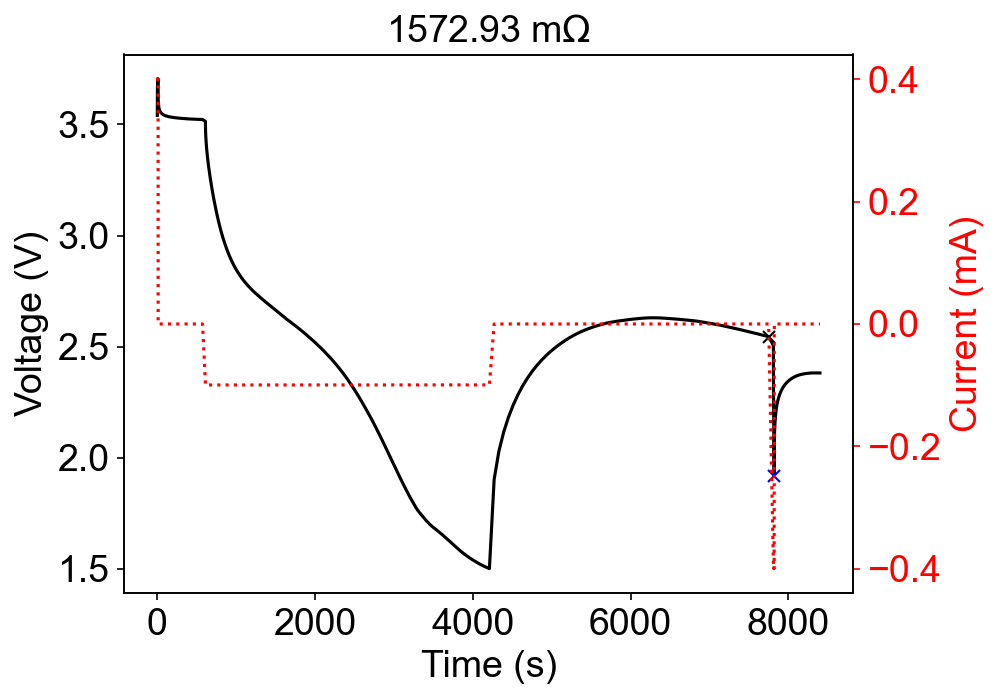

In [7]:
np.min(df['I/mA'])

cycle_number_vec = np.unique(df['cycle number'])

abs_time_vec = []
res_vec = []
ocv_vec = []

for cycle_number in cycle_number_vec[1:-1]:
    
    curr_df = df[df['cycle number'] == cycle_number]

    time = curr_df['time/s'] - curr_df['time/s'].iloc[0]
    
    fig, ax1 = plt.subplots()
    
    ax1.plot(time, curr_df['Ecell/V'], color='k')
    
    if is_cathode: # Take discharge
        idx1 = np.where(curr_df['I/mA'] < -0.35)[0][0] - 1 
        idx2 = np.where(curr_df['I/mA'] < -0.35)[0][-1]
    else: # Take charge
        idx1 = np.where(curr_df['I/mA'] > 0.35)[0][0] - 1 
        idx2 = np.where(curr_df['I/mA'] > 0.35)[0][-1]
        
    ax1.plot(time.iloc[idx1], curr_df['Ecell/V'].iloc[idx1], marker='x', color='k')
    ax1.plot(time.iloc[idx2], curr_df['Ecell/V'].iloc[idx2], marker='x', color='b')
  
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Voltage (V)')


    ax2 = ax1.twinx()
    ax2.plot(time, curr_df['I/mA'], color='r', linestyle=':')
    ax2.set_ylabel('Current (mA)')
    
    ax2.yaxis.label.set_color('r')        #setting up X-axis label color to yellow
    ax2.tick_params(axis='y', colors='red')  #setting up Y-axis tick color to black

    # Reistance computation
    res = np.abs((curr_df['Ecell/V'].iloc[idx1] - curr_df['Ecell/V'].iloc[idx2])) / np.abs(applied_current)
    
    ax1.set_title(f"{res * 1000 :.2f} m$\Omega$")

    abs_time_vec.append(curr_df['time/s'].iloc[idx1])
    res_vec.append(res)
    
    ocv_vec.append(curr_df['Ecell/V'].iloc[idx1])
    
    
ocv_vec = np.array(ocv_vec)
abs_time_vec = np.array(abs_time_vec)
res_vec = np.array(res_vec)

# Make the plots for each chemistry

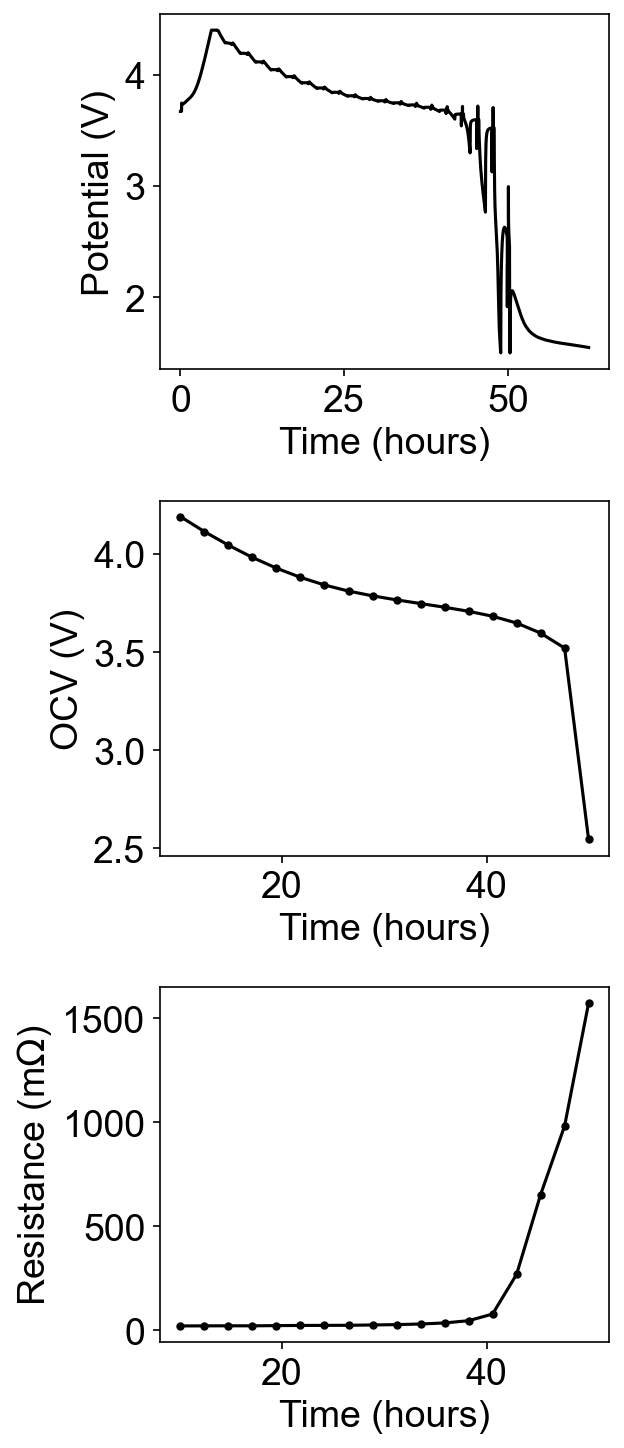

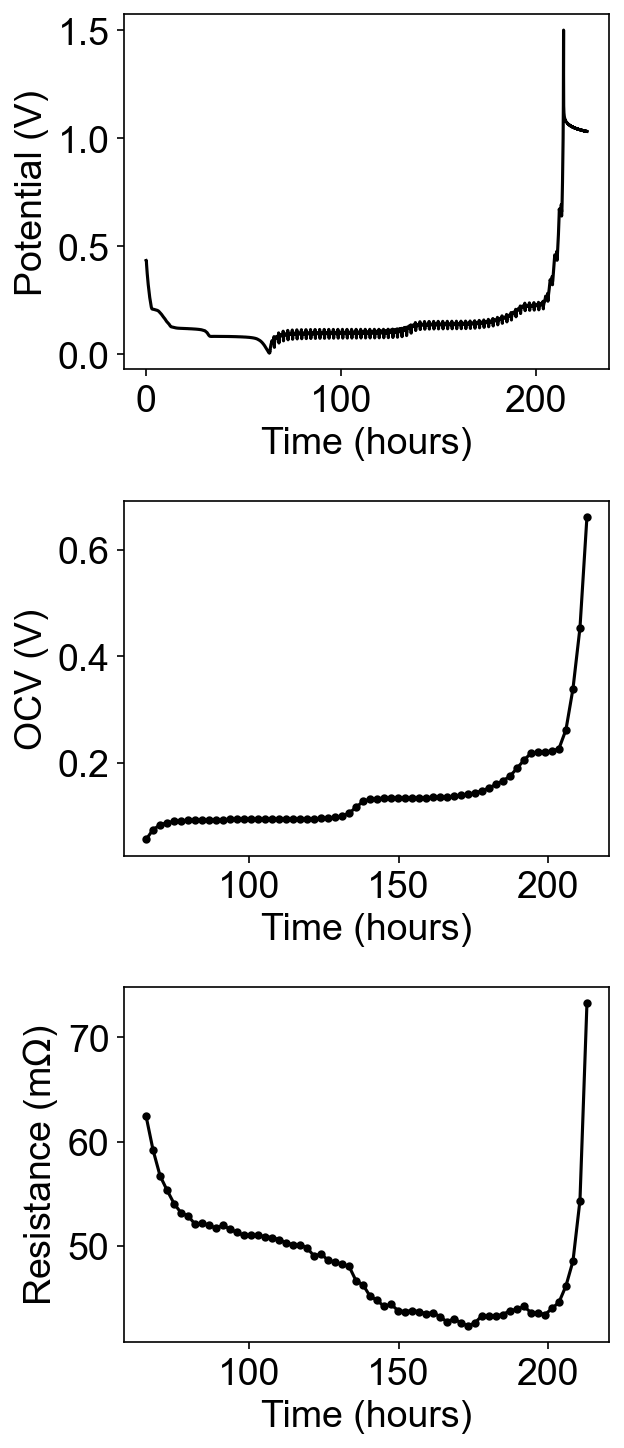

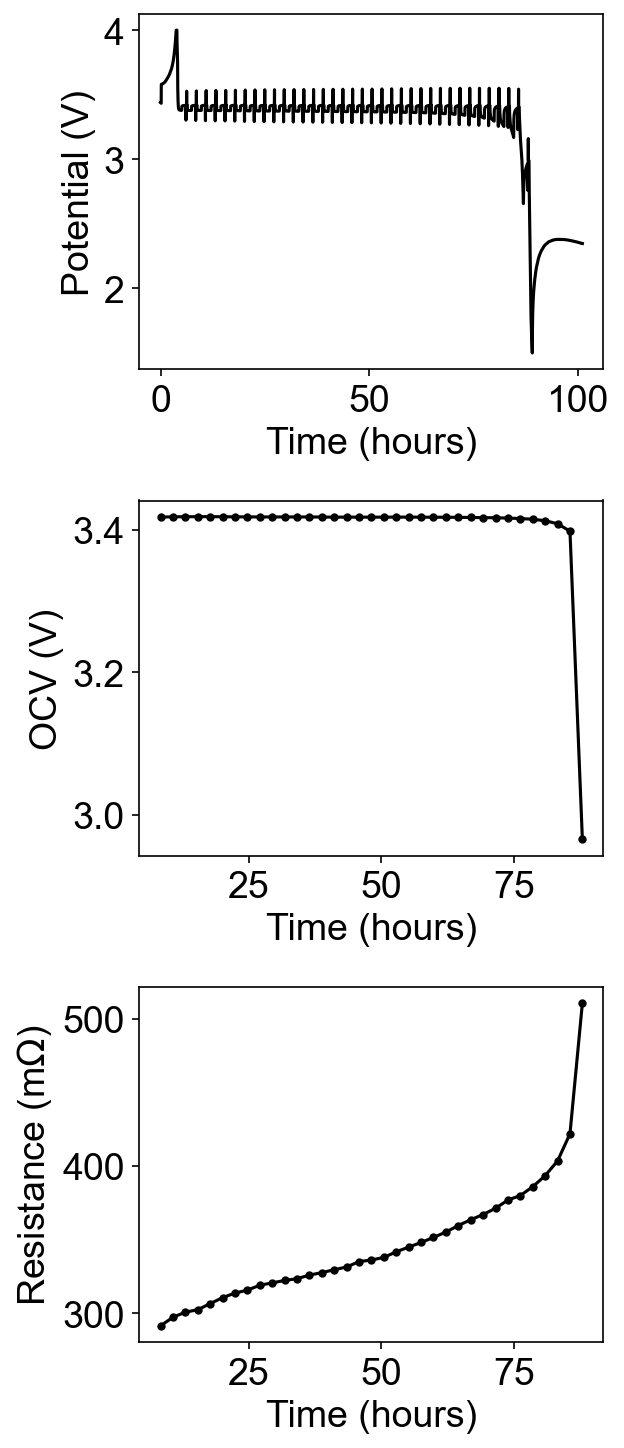

In [8]:
for target_file, num_header_lines, applied_current, is_cathode, name in \
    zip(target_files, num_header_lines_vec, applied_current_ma_vec, is_cathode_vec, name_vec):
    
    df = pd.read_csv(target_file, header=num_header_lines, sep='\t', encoding='ISO-8859-1')

    
    cycle_number_vec = np.unique(df['cycle number'])

    abs_time_vec = []
    res_vec = []
    ocv_vec = []

    for cycle_number in cycle_number_vec[1:-1]:

        curr_df = df[df['cycle number'] == cycle_number]

        time = curr_df['time/s'] - curr_df['time/s'].iloc[0]

        if is_cathode: # Take discharge
            idx1 = np.where(curr_df['I/mA'] < -0.35)[0][0] - 1 
            idx2 = np.where(curr_df['I/mA'] < -0.35)[0][-1]
        else: # Take charge
            idx1 = np.where(curr_df['I/mA'] > 0.35)[0][0] - 1 
            idx2 = np.where(curr_df['I/mA'] > 0.35)[0][-1]

        # Reistance computation
        res = np.abs((curr_df['Ecell/V'].iloc[idx1] - curr_df['Ecell/V'].iloc[idx2])) / np.abs(applied_current)

        abs_time_vec.append(curr_df['time/s'].iloc[idx1])
        res_vec.append(res)

        ocv_vec.append(curr_df['Ecell/V'].iloc[idx1])

    ocv_vec = np.array(ocv_vec)
    abs_time_vec = np.array(abs_time_vec)
    res_vec = np.array(res_vec)

    fig, axs = plt.subplots(3, figsize=(4.5,10))

    axs[0].plot(df['time/s'] / 3600, df['Ecell/V'], color='k')
    axs[0].set_xlabel('Time (hours)')
    axs[0].set_ylabel('Potential (V)')
    axs[0].set_title(name)

    axs[1].plot(abs_time_vec / 3600, ocv_vec, marker='o', markersize=3, color='k')
    axs[1].set_xlabel('Time (hours)')
    axs[1].set_ylabel('OCV (V)')

    axs[2].plot(abs_time_vec / 3600, res_vec * 1000, marker='o', markersize=3, color='k')
    axs[2].set_xlabel('Time (hours)')
    axs[2].set_ylabel('Resistance (m$\Omega$)')

    plt.savefig(f"{name}.png")